## N-queens with Ariel
This file demonstrates how to tackle the n-queens problem using Ariel. Solving for a board with n=8, n=16 and n=32 where n is the the board length and width and also the number of queens on the board. The goal is to achieve an average of zero attacking queens on all tested n values. This will demonstrate the power and usability of the Ariel library.

In [1]:
# Standard libraries
import random
import matplotlib.pyplot as plt
from typing import cast
import numpy as np

# Local libraries
from ariel.ec.a000 import IntegerMutator, IntegersGenerator
from ariel.ec.a001 import Individual
from ariel.ec.a005 import Crossover
from ariel.ec.a004 import EASettings, EAStep, EA

In [2]:
type Population = list[Individual]
config = EASettings()

In [3]:
def visualize_solution(solution):
    """Visualize the placement of queens on the chessboard."""
    n = len(solution)
    for i in range(n):
        e = '. '
        row_str = e * (solution[i]) + 'Q ' + e * ((n-1) - solution[i])
        print(row_str)
        
def count_attacking_queens(solution: list[int]) -> int:
    """Counts the number of attacking queens on diagonals."""
    fitness = 0
    main_diags, anti_diags = [], []
    
    for row, col in enumerate(solution):
       if row - col in main_diags:
          fitness += main_diags.count(row - col)
       if row + col in anti_diags:
          fitness += anti_diags.count(row + col)
      
       main_diags.append(row - col)
       anti_diags.append(row + col)       

    return fitness


In [4]:
def parent_selection(population: Population, k=2) -> Population:
    """Tournament selection of size k"""
    random.shuffle(population)
    for idx in range(1, len(population) - 1, k):
        ind_i = population[idx]
        ind_j = population[idx - 1]

        # Compare fitness values
        if ind_i.fitness < ind_j.fitness and not config.is_maximisation:
            ind_i.tags = {"ps": True}
            ind_j.tags = {"ps": False}
        else:
            ind_i.tags = {"ps": False}
            ind_j.tags = {"ps": True}
            
    return population


def crossover(population: Population) -> Population:
    """One-point crossover"""
    parents = [ind for ind in population if ind.tags.get("ps", False)] 
    for idx in range(1, len(parents), 2):
        parent_i = parents[idx - 1]
        parent_j = parents[idx]
        genotype_i, genotype_j = Crossover.order_cross(
            cast("list[int]", parent_i.genotype),
            cast("list[int]", parent_j.genotype),
        )

        # First child
        child_i = Individual()
        child_i.genotype = genotype_i
        child_i.tags = {"mut": True}
        child_i.requires_eval = True

        # Second child
        child_j = Individual()
        child_j.genotype = genotype_j
        child_j.tags = {"mut": True}
        child_j.requires_eval = True

        population.extend([child_i, child_j])
        
    return population


def mutation(population: Population) -> Population:
    """Swap mutation"""
    for ind in population:
        if ind.tags.get("mut", False):
            genes = cast("list[int]", ind.genotype)
            mutated = IntegerMutator.integer_swap(
                individual=genes,
                mutation_probability=0.1,
                swaps=1,
            )
            ind.genotype = mutated

    return population

def evaluate(population: Population) -> Population:
    """Evaluate individuals that require evaluation"""
    for ind in population:
        if ind.requires_eval:
            ind.fitness = count_attacking_queens(ind.genotype) 
            ind.requires_eval = False

    return population

def survivor_selection(population: Population) -> Population:
    """Tournament selection of size 2"""
    random.shuffle(population)
    current_pop_size = len(population)
    for idx in range(1, len(population), 2):
        ind_i = population[idx - 1]
        ind_j = population[idx]

        # Kill worse individual
        if ind_i.fitness < ind_j.fitness and not config.is_maximisation:
            ind_j.alive = False
        else:
            ind_i.alive = False

        # Termination condition
        current_pop_size -= 1
        if current_pop_size <= config.target_population_size:
            break

    return population


def create_individual(n) -> Individual:
    ind = Individual()
    ind.genotype = IntegersGenerator.integers(low=0, high=n-1, size=n, replace=False)
    ind.tags = {"ps": False, "mut": False} # Initially not selected for anything
    return ind


def learning(population: Population) -> Population:
    return population

In [5]:
def solve_problem(n, quiet=False) -> None:
    # Create initial population
    population_list = [create_individual(n) for _ in range(config.target_population_size)]
    population_list = evaluate(population_list)

    # Create EA steps
    ops = [
        EAStep("evaluation", evaluate),
        EAStep("parent_selection", parent_selection),
        EAStep("crossover", crossover),
        EAStep("mutation", mutation),
        EAStep("evaluation", evaluate),
        EAStep("survivor_selection", survivor_selection),
        EAStep("learning", learning),
    ]

    # Initialize EA
    ea = EA(
        population_list,
        operations=ops,
        num_of_generations=config.num_of_generations,
        quiet=quiet,
    )

    ea.run()
    
    return ea.get_solution(only_alive=True)

In [13]:
config.is_maximisation = False  # We want to minimize the number of attacking queens
config.target_population_size = 100
config.num_of_generations = 100
config.db_handling = "delete"

solution = solve_problem(32)
print("Best solution found:")
print(visualize_solution(solution.genotype))
print(f"With { int(solution.fitness) } attacking queens.")
print(count_attacking_queens(solution.genotype))

[20:17:53] Database file exists at                                                                       ]8;id=775327;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=35446;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py#99\99]8;;\
           /Users/jadenvanrijswijk/Downloads/ariel-dev/examples/__data__/database.db!                              
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Output()

─────────────────────────────────────────────── EA Finished Running ───────────────────────────────────────────────

Best solution found:
. . . . . . . . . . . . . . . . . . . . . . Q . . . . . . . . . 
. . . . . . . . . . Q . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . Q . . 
. . . . . . . . . . . . . . . . Q . . . . . . . . . . . . . . . 
. . . . . . . . . . . Q . . . . . . . . . . . . . . . . . . . . 
. . . . . Q . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . Q . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Q 
. . . . . . . . . . . . Q . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Q . 
. . . . . . . . . . . . . . . . . . Q . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . Q . . . . . . . . . . 
. . . . . . . . . . . . . . . . . Q . . . . . . . . . . . . . . 
Q . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . Q . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. Q 

In [7]:
print(solution)

alive=True time_of_birth=99 requires_eval=False id=4941 requires_init=False tags_={'mut': True, 'ps': True} time_of_death=100 fitness_=1.0 genotype_=[9, 12, 5, 2, 6, 1, 10, 4, 13, 15, 8, 11, 3, 7, 0, 14]


In [14]:
def calculate_mean_std(f_best):
    """This is a helper function to calculate the mean and standard deviation of the best fitness values."""
    f_best = np.array(f_best)
    avg = np.mean(f_best, axis=0)
    std = np.std(f_best, axis=0)
    return avg, std

def generate_subplot_function(
    avgs_experiment_1,
    stds_experiment_1,
    labels,
    avgs_experiment_2,
    stds_experiment_2,
    n_columns,
    n_queens,
):
    """This helper function generates subplots for the experiments."""
    fig, axes = plt.subplots(nrows=1, ncols=n_columns, figsize=(18, 6))

    for i in range(len(avgs_experiment_1)):
        if avgs_experiment_2 is not None:
            # Plot data for subplot 1
            axes[i].plot(avgs_experiment_2[i], label="Experiment 2", color="green")
            axes[i].fill_between(
                np.arange(len(avgs_experiment_2[i])),
                avgs_experiment_2[i] - stds_experiment_2[i],
                avgs_experiment_2[i] + stds_experiment_2[i],
                alpha=0.2,
                color="green",
            )
            axes[i].set_ylim(bottom=0)

            if n_queens:
                axes[i].set_ylim(top=n_queens[i])

        axes[i].plot(avgs_experiment_1[i], label="Experiment 1", color="blue")
        axes[i].fill_between(
            np.arange(len(avgs_experiment_1[i])),
            avgs_experiment_1[i] - stds_experiment_1[i],
            avgs_experiment_1[i] + stds_experiment_1[i],
            alpha=0.2,
            color="blue",
        )
        axes[i].set_title(labels[i])
        axes[i].set_ylim(bottom=0)
        if n_queens:
            axes[i].set_ylim(top=n_queens[i])

    # Set common labels and title
    for ax in axes:
        ax.set_xlabel("Generations")
        ax.set_ylabel("Average Best Fitness")
        ax.legend()

    plt.tight_layout()
    

def run_experiment_n_queens(runs):
    """Run the N-Queens experiment for different values of N."""
    fitness_8 = []
    fitness_16 = []
    fitness_32 = []

    for run in range(runs):
        print("Run: ", run+1)

        # N = 8
        solution = solve_problem(8, quiet=True)
        fitness_8.append(solution.fitness)
        visualize_solution(solution.genotype)
        
        # N = 16
        solution = solve_problem(16, quiet=True)
        fitness_16.append(solution.fitness)
        
        # N = 32
        solution = solve_problem(32, quiet=True)
        fitness_32.append(solution.fitness)
        
        visualize_solution(solution.genotype)

    avg_8, std_8 = calculate_mean_std(fitness_8)
    avg_16, std_16 = calculate_mean_std(fitness_16)
    avg_32, std_32 = calculate_mean_std(fitness_32)

    avgs = [avg_8, avg_16, avg_32]
    stds = [std_8, std_16, std_32]
    all_runs = [fitness_8, fitness_16, fitness_32]

    return avgs, stds, all_runs

In [ ]:
config.is_maximisation = False  # We want to minimize the number of attacking queens
config.target_population_size = 10
config.num_of_generations = 10
config.db_handling = "delete"
runs = 10

#check for the best fitness found for each problem
avgs_experiment_1, stds_experiment_1, all_runs_experiment_1 = run_experiment_n_queens(runs)

f_8, f_16, f_32 = all_runs_experiment_1

print("Best fitness found for N = 8: ", min(f_8))
print("Best fitness found for N = 16: ", min(f_16))
print("Best fitness found for N = 32: ", min(f_32))

Run:  1


[20:18:11] Database file exists at                                                                       ]8;id=439499;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=726123;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py#99\99]8;;\
           /Users/jadenvanrijswijk/Downloads/ariel-dev/examples/__data__/database.db!                              
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

. . . . Q . . . 
. . . . . . . Q 
. . . . . Q . . 
. . . Q . . . . 
. Q . . . . . . 
. . . . . . Q . 
Q . . . . . . . 
. . Q . . . . . 


           Database file exists at                                                                       ]8;id=259071;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=215795;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py#99\99]8;;\
           /Users/jadenvanrijswijk/Downloads/ariel-dev/examples/__data__/database.db!                              
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

           Database file exists at                                                                       ]8;id=387096;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=102049;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py#99\99]8;;\
           /Users/jadenvanrijswijk/Downloads/ariel-dev/examples/__data__/database.db!                              
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

. . . . . . Q . . . . . . . . . . . . . . . . . . . . . . . . . 
. Q . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Q . 
. . . . . . . . . . . Q . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . Q . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . Q . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . Q . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . Q . . . . . . . 
. . . . . . . Q . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . Q . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . Q . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . Q . . . . . . . . 
. . . . . Q . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . Q . . . . 
Q . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . .

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 labels = ["N = 8", "N = 16", "N = 32"]                                                      │
│    2                                                                                             │
│ ❱  3 generate_subplot_function(                                                                  │
│    4 │   avgs_experiment_1,                                                                      │
│    5 │   stds_experiment_1,                                                                      │
│    6 │   labels,                                                                                 │
│                                                                                                  │
│ in generate_subplot_function:38                                                                  │
│                                                                                                  │
│   35 │   │                                                                                       │
│   36 │   │   axes[i].plot(avgs_experiment_1[i], label="Experiment 1", color="blue")              │
│   37 │   │   axes[i].fill_between(                                                               │
│ ❱ 38 │   │   │   np.arange(len(avgs_experiment_1[i])),                                           │
│   39 │   │   │   avgs_experiment_1[i] - stds_experiment_1[i],                                    │
│   40 │   │   │   avgs_experiment_1[i] + stds_experiment_1[i],                                    │
│   41 │   │   │   alpha=0.2,                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: object of type 'numpy.float64' has no len()

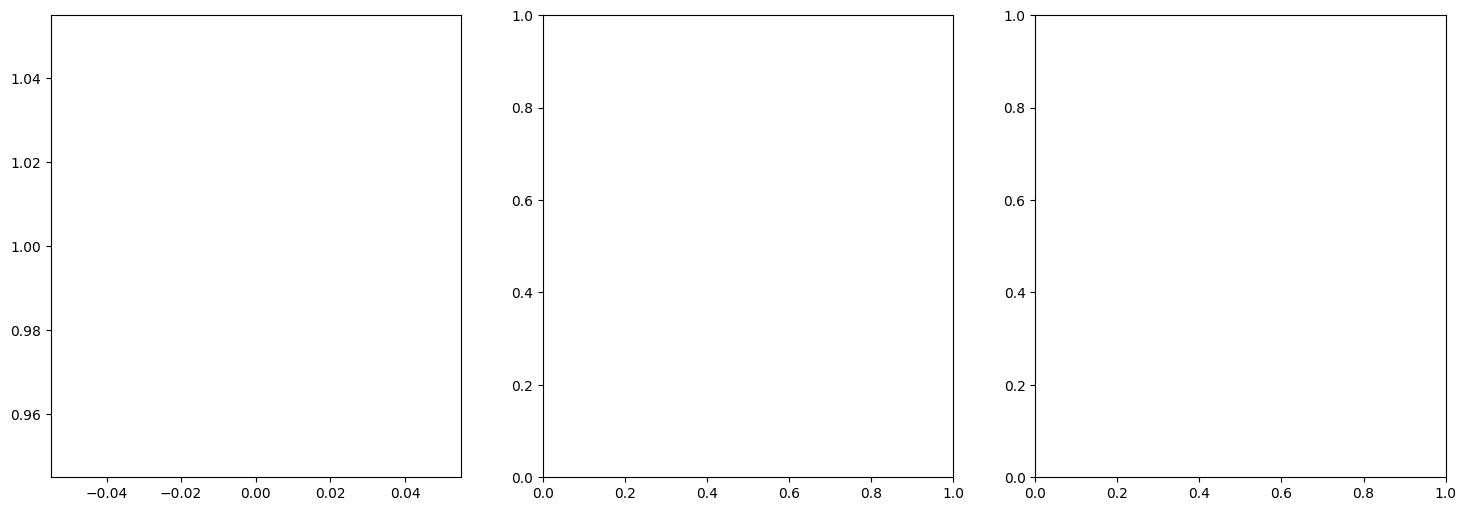

In [10]:
labels = ["N = 8", "N = 16", "N = 32"]

generate_subplot_function(
    avgs_experiment_1,
    stds_experiment_1,
    labels,
    avgs_experiment_2=None,
    stds_experiment_2=None,
    n_columns=3,
    n_queens=[8, 16, 32],
)